In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
# Make a Dataset

batch_size = 32
image_size = 256

dataset = keras.preprocessing.image_dataset_from_directory(directory=os.path.join('dataset', 'PlantVillage'),
                                                           batch_size=batch_size,
                                                           image_size=(image_size, image_size),
                                                           shuffle=True)
dataset

Found 2948 files belonging to 3 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

93

In [6]:
93 * batch_size

2976

In [7]:
# No of images in last badge

32 - (2976 - 2948)

4

In [8]:
def train_validation_test_split(dataset, train_size=0.8, validation_size=0.1, test_size=0.1, shuffle=True, shuffle_size=10000):

    dataset_batch_count = len(dataset)
    train_batch_count = int(dataset_batch_count * train_size)
    validation_test_batch_count = int(dataset_batch_count * validation_size)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=shuffle_size)

    train_ds = dataset.take(train_batch_count)
    validation_ds = dataset.skip(train_batch_count).take(validation_test_batch_count)
    test_ds = dataset.skip(train_batch_count).skip(validation_test_batch_count)

    return train_ds, validation_ds, test_ds

In [9]:
train_ds, validation_ds, test_ds = train_validation_test_split(dataset)
len(train_ds), len(validation_ds), len(test_ds)

(74, 9, 10)

(256, 256, 3)
[[[136. 121. 126.]
  [136. 121. 126.]
  [137. 122. 127.]
  ...
  [128. 114. 113.]
  [134. 120. 119.]
  [145. 131. 130.]]

 [[137. 122. 127.]
  [136. 121. 126.]
  [136. 121. 126.]
  ...
  [122. 108. 107.]
  [125. 111. 110.]
  [129. 115. 114.]]

 [[143. 128. 133.]
  [140. 125. 130.]
  [138. 123. 128.]
  ...
  [131. 117. 116.]
  [133. 119. 118.]
  [132. 118. 117.]]

 ...

 [[181. 172. 177.]
  [180. 171. 176.]
  [175. 166. 171.]
  ...
  [181. 173. 171.]
  [184. 176. 174.]
  [187. 179. 177.]]

 [[179. 170. 175.]
  [178. 169. 174.]
  [173. 164. 169.]
  ...
  [184. 176. 174.]
  [182. 174. 172.]
  [181. 173. 171.]]

 [[187. 178. 183.]
  [185. 176. 181.]
  [181. 172. 177.]
  ...
  [184. 176. 174.]
  [178. 170. 168.]
  [172. 164. 162.]]]

(32,)
1



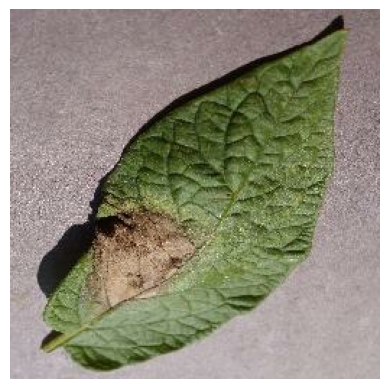

In [11]:
for image_batch, label_batch in train_ds.take(1):
    print(image_batch.numpy()[0].shape)
    print(image_batch.numpy()[0])
    print()

    print(label_batch.numpy().shape)
    print(label_batch.numpy()[0])
    print()

    plt.imshow(image_batch.numpy()[0].astype('uint8'))
    plt.axis('off')

In [12]:
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
# Build Data Pipeline

train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

In [14]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [15]:
channel = 3  # RGB
input_shape = (batch_size, image_size, image_size, channel)
target = 3  # len(class_names)

input_shape

(32, 256, 256, 3)

In [16]:
# Image Data Preprocessing

preprocessing = keras.Sequential([
                    keras.layers.Resizing(height=image_size, width=image_size),
                    keras.layers.Rescaling(scale=1./255),
                    keras.layers.RandomFlip(mode='horizontal_and_vertical'),
                    keras.layers.RandomRotation(factor=0.2)
                ])
preprocessing

In [17]:
# Build CNN Architecture

model = keras.Sequential([
            # CNN
            preprocessing,
            keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),

            keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),

            # ANN
            keras.layers.Flatten(),
            keras.layers.Dense(units=64, activation='relu'),
            keras.layers.Dense(units=target, activation='softmax')
        ])
model

In [18]:
model.build(input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [19]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model

In [20]:
history = model.fit(train_ds,
                    batch_size=batch_size,
                    epochs=35,
                    verbose=1,
                    validation_data = validation_ds)
history

Epoch 1/35
74/74 [==============================] - 32s 207ms/step - loss: 0.6853 - accuracy: 0.6568 - val_loss: 0.4503 - val_accuracy: 0.8160
Epoch 2/35
74/74 [==============================] - 5s 62ms/step - loss: 0.3119 - accuracy: 0.8701 - val_loss: 0.3776 - val_accuracy: 0.8368
Epoch 3/35
74/74 [==============================] - 5s 62ms/step - loss: 0.2801 - accuracy: 0.8859 - val_loss: 0.1945 - val_accuracy: 0.9271
Epoch 4/35
74/74 [==============================] - 4s 60ms/step - loss: 0.2071 - accuracy: 0.9269 - val_loss: 0.1887 - val_accuracy: 0.9236
Epoch 5/35
74/74 [==============================] - 5s 62ms/step - loss: 0.2029 - accuracy: 0.9218 - val_loss: 0.2195 - val_accuracy: 0.9132
Epoch 6/35
74/74 [==============================] - 4s 60ms/step - loss: 0.1156 - accuracy: 0.9632 - val_loss: 0.1297 - val_accuracy: 0.9479
Epoch 7/35
74/74 [==============================] - 4s 59ms/step - loss: 0.0969 - accuracy: 0.9641 - val_loss: 0.1352 - val_accuracy: 0.9479
Epoch 8/35


In [21]:
model.evaluate(test_ds)

10/10 [==============================] - 10s 27ms/step - loss: 0.0335 - accuracy: 0.9937


[0.03347916528582573, 0.9937499761581421]

In [22]:
history.params

{'verbose': 1, 'epochs': 35, 'steps': 74}

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [25]:
acc[0:5]

[0.6568375825881958,
 0.8700854778289795,
 0.8858974575996399,
 0.9269230961799622,
 0.9217948913574219]

In [26]:
len(acc), len(val_acc), len(loss), len(val_loss)

(35, 35, 35, 35)

In [27]:
model.save('model.h5')

Text(0.5, 1.0, 'Training vs Validation Loss')

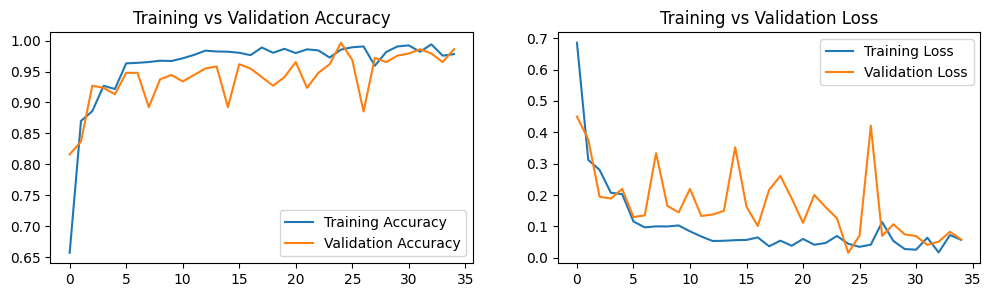

In [28]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

In [29]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [30]:
def prediction(image_path, class_names = dataset.class_names):

    img = Image.open(image_path).resize((256,256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    model = tf.keras.models.load_model('model.h5')
    prediction = model.predict(img_array)

    predicted_class = class_names[np.argmax(prediction)]
    confidence = round(np.max(prediction)*100, 2)

    print(f'Predicted Class : {predicted_class}')
    print(f'Confident : {confidence}%')
    print('')
    plt.imshow(img)
    plt.axis('off')


1/1 [==============================] - 0s 473ms/step
Predicted Class : Potato___Early_blight
Confident : 100.0%



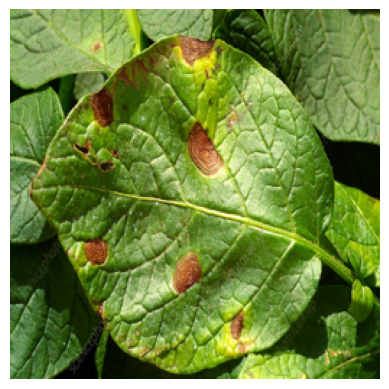

In [32]:
prediction(image_path='potato_early_blight.jpg')

1/1 [==============================] - 0s 96ms/step
Predicted Class : Potato___Late_blight
Confident : 93.74%



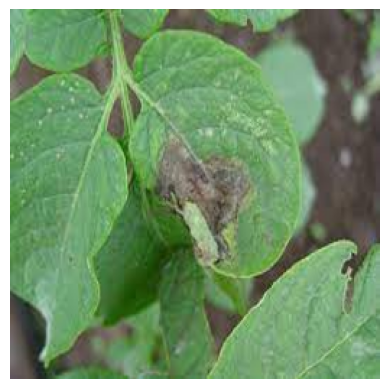

In [33]:
prediction(image_path='potato_late_blight.jpg')

1/1 [==============================] - 0s 101ms/step
Predicted Class : Potato___healthy
Confident : 99.94%



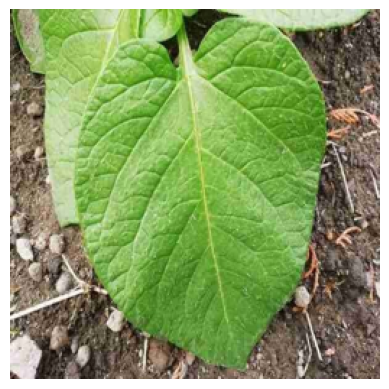

In [34]:
prediction(image_path='potato_healthy.jpg')